<a href="https://colab.research.google.com/github/Clarkdrengen/PML_2023/blob/main/PML_Part_A_Team_Master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

In [13]:
torch.manual_seed(1)
batch_size = 128
learning_rate = 1e-3
epochs = 10
#device = "cpu"
device = "gpu"
log_interval = 10
args = {0}
kwargs = {}
device = torch.device("cpu")

In [14]:
train_temp = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())
train_temp.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [15]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=False, **kwargs)

In [16]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 2)
        self.fc22 = nn.Linear(400, 2)
        self.fc3 = nn.Linear(2, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [17]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

loss_record = []

In [18]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        if (batch_idx == 0):
            loss_record.append(loss.item())
        train_loss += loss.item()
        optimizer.step()
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
'''
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
'''

"\n        if batch_idx % log_interval == 0:\n            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(\n                epoch, batch_idx * len(data), len(train_loader.dataset),\n                100. * batch_idx / len(train_loader),\n                loss.item() / len(data)))\n\n    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))\n"

In [19]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'reconstruction_2_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [21]:
if __name__ == "__main__":
    for epoch in range(1, epochs + 1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            #sample = torch.randn(64, 20).to(device)
            sample = torch.randn(64, 2).to(device)
            #sample = model.decode(sample).gpu()
            sample = model.decode(sample).to(device)
            save_image(sample.view(64, 1, 28, 28), 'sample' + str(epoch) + '.png')

====> Epoch: 1 Average loss: 168.2798
====> Test set loss: 165.0761
====> Epoch: 2 Average loss: 163.9109
====> Test set loss: 162.1407
====> Epoch: 3 Average loss: 161.6570
====> Test set loss: 160.3725
====> Epoch: 4 Average loss: 159.9565
====> Test set loss: 158.6599
====> Epoch: 5 Average loss: 158.4899
====> Test set loss: 157.4821
====> Epoch: 6 Average loss: 157.1542
====> Test set loss: 156.4209
====> Epoch: 7 Average loss: 155.9515
====> Test set loss: 155.4481
====> Epoch: 8 Average loss: 155.0221
====> Test set loss: 154.9034
====> Epoch: 9 Average loss: 154.2436
====> Test set loss: 154.3296
====> Epoch: 10 Average loss: 153.5854
====> Test set loss: 153.7285


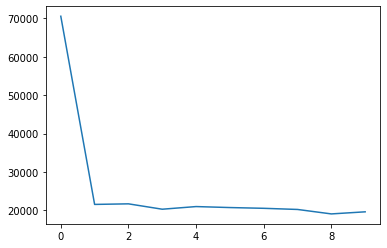

In [ ]:
plt.plot(loss_record)

# New section

In [ ]:
print(f"Length of train_loader: {len(train_loader)} batches of size {batch_size}...")
print(f"Length of test_loader: {len(test_loader)} batches of size {batch_size}...")
test_features_batch, test_labels_batch = next(iter(test_loader))
test_features_batch.shape, test_labels_batch.shape

Length of train_loader: 469 batches of size 128...
Length of test_loader: 79 batches of size 128...


(torch.Size([128, 1, 28, 28]), torch.Size([128]))

Image size: torch.Size([1, 28, 28])
Label: 1


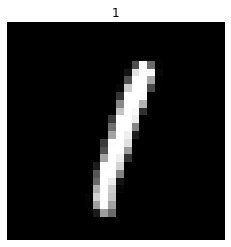

In [ ]:
# Show a random sample
random_idx = torch.randint(0, len(test_features_batch), size=[1]).item()
img, label = test_features_batch[random_idx], test_labels_batch[random_idx]

plt.imshow(img.squeeze(), cmap="gray")
plt.title(int(test_labels_batch[random_idx]))
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {test_labels_batch[random_idx]}")

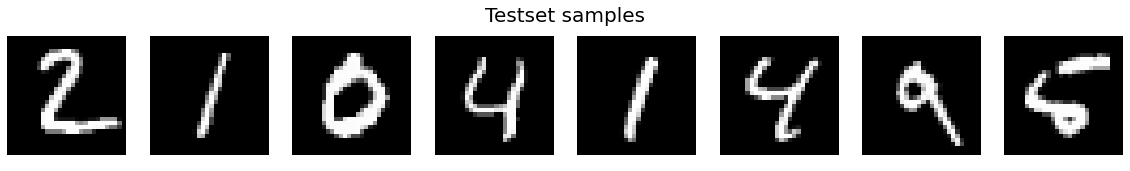

In [ ]:
# Show a bunch of examples
# https://www.youtube.com/watch?v=Z_ikDlimN6A&t=31924s @ 14:59:01
fig = plt.figure(figsize = (20,2.5))
plt.title("Testset samples", fontsize = 20)
plt.axis(False)

rows, cols = 1, 8
for i in range(1, rows*cols+1):
  img, label = test_features_batch[i], test_labels_batch[i]
  fig.add_subplot(rows, cols, i)
  plt.axis(False)
  plt.imshow(img.squeeze(), cmap="gray")
  

In [ ]:
len(test_features_batch)
#test_features_batch[3]
#plt.imshow(img.squeeze(), cmap="gray")

NameError: ignored

Implement ConvNet VAE
blog: https://towardsdatascience.com/building-a-convolutional-vae-in-pytorch-a0f54c947f71
code: https://github.com/ttchengab/VAE/blob/main/VAE.ipynb


In [ ]:
class ConvNet_VAE(nn.Module):
    def __init__(self, imgChannels=1, featureDim=32*20*20, zDim=256):
        super(ConvNet_VAE, self).__init__()
        
        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 16, 5)
        self.encConv2 = nn.Conv2d(16, 32, 5) 
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)
        
        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 5)
        self.decConv2 = nn.ConvTranspose2d(16, imgChannels, 5)
        
    def encoder(self, x):
        
        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = x.view(-1, 32*20*20)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar
    
    def reparameterize(self, mu, logVar):
        
        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps
    
    def decoder(self, z):
        
        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.decFC1(z))
        x = x.view(-1, 32, 20, 20)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x
        
    def forward(self, x):
        
        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar

In [ ]:
net = ConvNet_VAE().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(epochs):
    for idx, data in enumerate(train_loader, 0):
        imgs, _ = data
        imgs = imgs.to(device)
        
        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logVar = net(imgs)
        
        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        kl_divergence = -0.5 * torch.sum(1 + logVar - mu.pow(2) - logVar.exp())
        loss = F.binary_cross_entropy(out, imgs, size_average=False) + kl_divergence
        
        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Epoch {}: Loss {}'.format(epoch, loss))

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: Loss 11903.9560546875
Epoch 1: Loss 11239.708984375
Epoch 2: Loss 10914.7119140625
Epoch 3: Loss 10623.4267578125
Epoch 4: Loss 9987.47265625
Epoch 5: Loss 10428.3818359375
Epoch 6: Loss 10523.01171875
Epoch 7: Loss 9739.1181640625
Epoch 8: Loss 10099.953125
Epoch 9: Loss 9839.056640625


In [ ]:
imgs.shape

torch.Size([96, 1, 28, 28])

<ipython-input-36-d013f242c925>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_subplot(rows, cols, i)


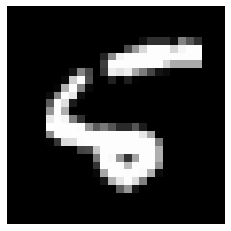

In [ ]:
rows, cols = 1, 8
for i in range(1, rows*cols+1):
  img, label = test_features_batch[i], test_labels_batch[i]
  fig.add_subplot(rows, cols, i)
  plt.axis(False)
  plt.imshow(img.squeeze(), cmap="gray")

In [ ]:
test_features_batch.shape

torch.Size([128, 1, 28, 28])

In [ ]:
rows

1

In [ ]:
cols

8